In [2]:
import pandas as pd
import re
#import graphlab
import matplotlib.pyplot as plt

import nltk
import nltk.data
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import sent_tokenize, word_tokenize 

from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer

In [3]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [4]:
stopwords = nltk.corpus.stopwords.words('english')

## Load the data

In [5]:
df = pd.read_csv('in.tsv', sep="\t", header=None, names = ['filename', 'keys', 'text_djvu', 'text_tesseract', 'text_textract', 'text_best'])

In [7]:
df.head()

,filename,keys,text_djvu,text_tesseract,text_textract,text_best
0,008482cf51383c158b54e593cfa5fbf7.pdf,address__post_town address__postcode address__...,TAR\n1\nAugust 2016\nTrustees' Annual Report f...,CHARITY Trustees’' Annual Report for the perio...,CHARITY\nTrustees' Annual Report for the perio...,TAR\n1\nAugust 2016\nTrustees' Annual Report f...
1,009fab39d746267b6de8428366fe4b02.pdf,address__post_town address__postcode address__...,"\fAnnual Report 2015-2017 July, 2017\nStepping...",\n; Na {if anv)\n{\noA el\nC 3 QIC [1€d C\nf (...,Charity Name\nNo lif anv)\nStepping Stone Thea...,\n; Na {if anv)\n{\noA el\nC 3 QIC [1€d C\nf (...
2,01c7fd563327947c68abdd9717ef228d.pdf,address__post_town address__postcode address__...,Promoting Independent Living\nCelebrating new\...,54 S ke *\nB\n \nWelcome to our Annual\nReport...,Promoting Independent Living\nAbility\nAbility...,54 S ke *\nB\n \nWelcome to our Annual\nReport...
3,01d804edf76bec4912d2466908a60889.pdf,address__post_town address__postcode address__...,Annual Repor t 8\nAccounts 2017/18\nYear ended...,Annual Report &\nAccounts 2017//183\nYear ende...,Annua Report &\nAccounts 2017/18\nYear ended 3...,Annual Repor t 8\nAccounts 2017/18\nYear ended...
4,01e4461b059e707b7d8276b3d2b80b71.pdf,address__post_town address__postcode address__...,"The Greenway Centre\n(Registered charity, numb...","The Greenway Centre\n(Registered charity, numb...","The Greenway Centre\n(Registered charity, numb...","The Greenway Centre\n(Registered charity, numb..."


In [8]:
df.shape

(1729, 6)

In [9]:
df.dtypes

filename          object
keys              object
text_djvu         object
text_tesseract    object
text_textract     object
text_best         object
dtype: object

In [10]:
df.dropna(inplace=True)

## Explore the data

In [42]:
pdf = df[df['filename'] == '01c7fd563327947c68abdd9717ef228d.pdf']

In [43]:
pdf

,filename,keys,text_djvu,text_tesseract,text_textract,text_best
2,01c7fd563327947c68abdd9717ef228d.pdf,address__post_town address__postcode address__...,Promoting Independent Living Celebrating new H...,54 S ke * B Welcome to our Annual Report for...,Promoting Independent Living Ability Ability A...,54 S ke * B Welcome to our Annual Report for...


In [115]:
pdf['text_textract']

2    promoting independent living ability ability a...
Name: text_textract, dtype: object

In [68]:
df = df.replace(r'\\n',' ', regex=True)

In [72]:
#df.loc[:, ["text_textract"]].iloc[1682].values

## Word counts

In [69]:
df['text_textract']

0       CHARITY Trustees' Annual Report for the period...
1       Charity Name No lif anv) Stepping Stone Theatr...
2       Promoting Independent Living Ability Ability A...
3       Annua Report & Accounts 2017/18 Year ended 31 ...
4       The Greenway Centre (Registered charity, numbe...
                              ...                        
1724    CHARITY Trustees' Annual Report for the period...
1725    The Gordon Russell Trust Charity No. 326446 Tr...
1726    FRIENDS OF EZRA Charity No CHARITY (if any) 11...
1727    CASPARI FOUNDATION (Company Number 3815700) (R...
1728    REGISTERED COMPANY NUMBER: 09623674 (England a...
Name: text_textract, Length: 1683, dtype: object

In [11]:
# Cleaning text and lower casing all words
for char in '-.,\n':
    df['text_textract'] = df['text_textract'].replace(char,' ')
df['text_textract'] = df['text_textract'].str.lower()

In [49]:
# split returns a list of words delimited by sequences of whitespace (including tabs, newlines, etc, like re's \s) 
#word_list = df['text_textract'].str.split()
#word_list

In [71]:
word_count = df['text_textract'].str.split(expand=True).stack().value_counts()

In [72]:
word_count

the           648697
of            327441
and           326441
to            246930
in            178628
               ...  
75,539             1
(26/1112)          1
iridescent         1
arusha             1
613.68             1
Length: 322186, dtype: int64

In [12]:
# Load nltk's SnowballStemmer as variable 'stemmer'
stemmer = SnowballStemmer("english")

In [13]:
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

In [14]:
# Define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

In [15]:
tfidf_matrix = tfidf_vectorizer.fit_transform(df['text_textract'])

/home/becode/.local/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


In [16]:
print(tfidf_matrix.shape)

(1683, 1571)


In [17]:
type(tfidf_matrix)

scipy.sparse.csr.csr_matrix

In [18]:
terms = tfidf_vectorizer.get_feature_names()

In [74]:
#terms

In [145]:
#df['filename']

# K-MEANS

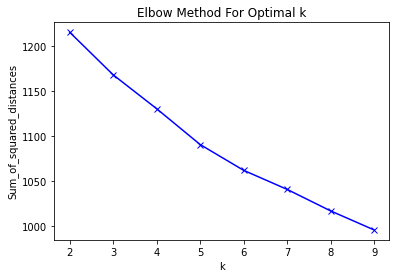

In [19]:
Sum_of_squared_distances = []
K = range(2,10)

for k in K:
    km = KMeans(n_clusters=k, max_iter=200, n_init=10)
    km = km.fit(tfidf_matrix)
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [53]:
true_k = 6
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=200, n_init=10)
model.fit(tfidf_matrix)
labels = model.labels_
df_cl = pd.DataFrame(list(zip(df['filename'],labels)),columns = ['filename','cluster'])
print(df_cl.sort_values(by = ['cluster']))

                                  filename  cluster
1682  ffcc30999650db76144fe4ff91b60e0e.pdf        0
1444  dba37765dd23d56ac95ebcfe41715b4b.pdf        0
731   69baac8d3f29a07c5db6afc2256e63bc.pdf        0
338   30c0cac98e43cf687162e6890bb08faf.pdf        0
1446  dbd6a1779c4bc6113014fcb26d7ee229.pdf        0
...                                    ...      ...
849   7943c761a7d7ebe69f25a6997b94eb0e.pdf        5
1443  db54dd6794d4c9f17fd1a6a6fe2eb0a2.pdf        5
1320  c6e5ded6f6d2224536bb4663d62688bf.pdf        5
1566  ec7cedbac6730ee9328b6e73bea72b9f.pdf        5
573   519c34b0eda356fedb2db339b4a0fcad.pdf        5

[1683 rows x 2 columns]


In [54]:
X = tfidf_matrix.toarray()

In [55]:
y = model.predict(X)

In [56]:
from numpy import unique
# retrieve unique clusters
clusters = unique(y)
print(clusters)

[0 1 2 3 4 5]


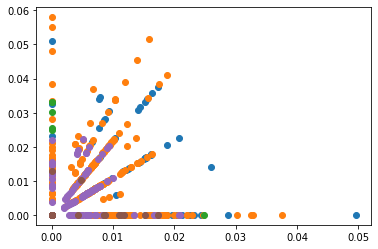

In [57]:
from numpy import where

for cluster in clusters:
    # get row indexes for samples with this cluster
    row_ix = where(y== cluster)
    x_pos, y_pos = X[row_ix, 0], X[row_ix, 1]
    # create scatter of these samples
    plt.scatter(x_pos, y_pos)
# show the plot
plt.show()

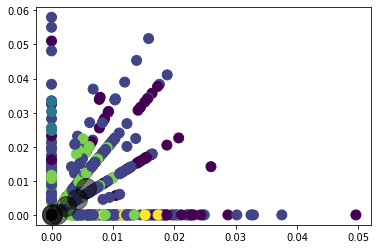

In [61]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=100, cmap='viridis')

centers = model.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=400, alpha=0.5);

In [ ]:
#using cosine similarity --> predict

Cluster: 0


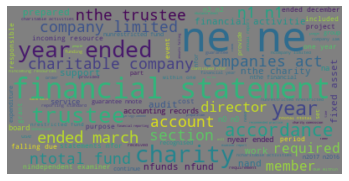

Cluster: 1


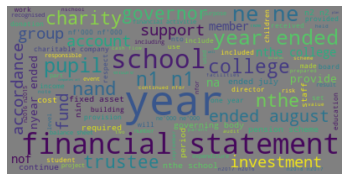

Cluster: 2


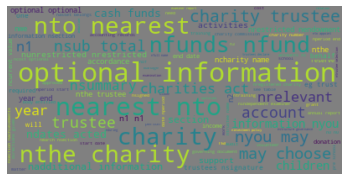

Cluster: 3


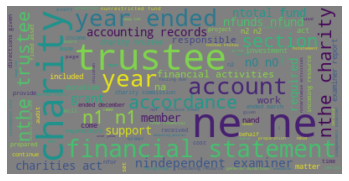

Cluster: 4


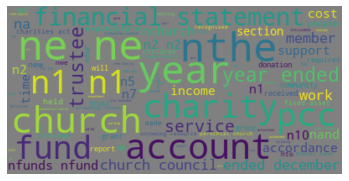

Cluster: 5


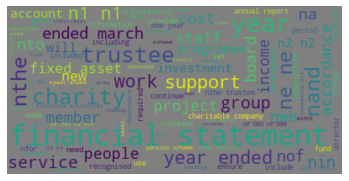

In [159]:
from wordcloud import WordCloud
result={'cluster':labels,'pdf':df['text_textract']}
result=pd.DataFrame(result)
for k in range(0,true_k):
    s=result[result.cluster==k]
    text=s['pdf'].str.cat(sep=' ')
    text=text.lower()
    text=' '.join([word for word in text.split()])
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="grey").generate(text)
    print('Cluster: {}'.format(k))
    #print('Titles')
    titles=df_cl[df_cl.cluster==k]['filename']         
    #print(titles.to_string(index=False))
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [69]:
num_clusters = 10

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)

y = km.predict(X)

x_tran = km.fit_transform(tfidf_matrix)

clusters = km.labels_.tolist()

CPU times: user 9.34 s, sys: 56.2 ms, total: 9.39 s
Wall time: 3.16 s


In [ ]:
#fit transform the tfidf matrix --> distance 

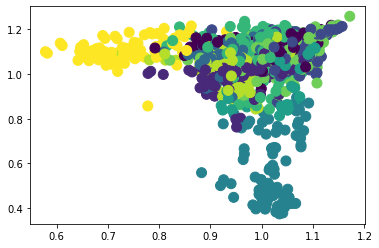

In [70]:
plt.scatter(x_tran[:, 0], x_tran[:, 1], c=y, s=100, cmap='viridis')

In [46]:
#print(clusters)

In [63]:
km.labels_

array([ 0, 16,  4, ..., 23, 13, 15], dtype=int32)

In [49]:
pdf = {'cluster': clusters}

frame = pd.DataFrame(pdf, index = [clusters] , columns = ['cluster'])

frame['cluster'].value_counts() #number of films per cluster (clusters from 0 to 4)

6     123
29    104
12    101
28     94
19     93
3      83
20     78
5      74
16     72
0      72
11     66
26     61
22     59
1      56
18     55
10     54
4      52
24     48
2      47
7      45
8      44
25     35
9      34
21     26
23     25
13     23
14     18
27     17
17     16
15      8
Name: cluster, dtype: int64

In [64]:
# retrieve unique clusters
clusters = unique(y)
print(clusters)

[0.32563761 0.33378503 0.34289096 ... 1.32829858 1.32928659 1.34216933]


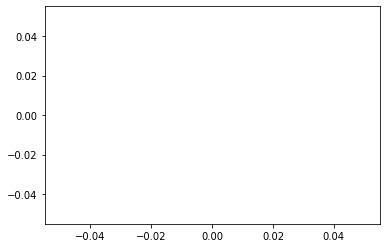

In [67]:
for cluster in clusters:
    # get row indexes for samples with this cluster
    row_ix = where(y== cluster)
    x_pos, y_pos = X[row_ix, 0], X[row_ix, 1]
    # create scatter of these samples
    plt.scatter(x_pos, y_pos)
# show the plot
plt.show()

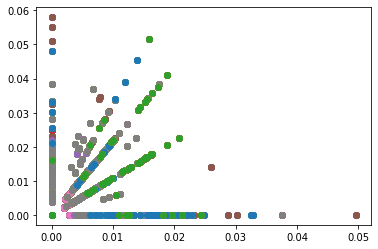

In [44]:
for cluster in clusters:
    # get row indexes for samples with this cluster
    row_ix = where(y== cluster)
    x_pos, y_pos = X[row_ix, 0], X[row_ix, 1]
    # create scatter of these samples
    plt.scatter(x_pos, y_pos)
# show the plot
plt.show()

# DBSCAN

[-1 -1 -1 ... -1 -1 -1]
[-1  0]


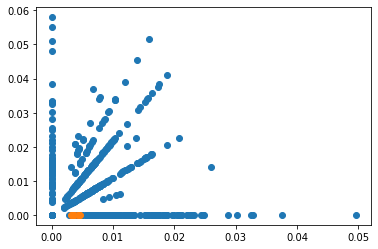

In [58]:
# dbscan clustering
from numpy import unique
from numpy import where
from sklearn.cluster import DBSCAN
from matplotlib import pyplot

# define dataset
X = tfidf_matrix.toarray()

# define the model
DB = DBSCAN(eps=0.3, min_samples=8)

# fit model and predict clusters
y_db = DB.fit_predict(X)
print(y_db)

# retrieve unique clusters
clusters = unique(y_db)
print(clusters)

# create scatter plot for samples from each cluster
for cluster in clusters:
    # get row indexes for samples with this cluster
    row_ix = where(y_db == cluster)
    x_pos, y_pos = X[row_ix, 0], X[row_ix, 1]
    # create scatter of these samples
    plt.scatter(x_pos, y_pos)
# show the plot
plt.show()

### expected.tsv

In [123]:
d = pd.read_csv('KleisterDataset/kleister-charity/train/expected.tsv', sep=' ', header=None)

In [126]:
d.head(15)

,0,1,2,3,4,5,6,7
0,address__post_town=OLDHAM,address__postcode=OL3_5DE,address__street_line=DELPH_NEW_ROAD,charity_name=Pc_Nicola_Hughes_Memorial_Fund,charity_number=1156398,income_annually_in_british_pounds=103373.00,report_date=2016-04-29,spending_annually_in_british_pounds=43497.00
1,address__post_town=GAINSBOROUGH,address__postcode=DN21_3JZ,address__street_line=3_CHURCH_LANE,charity_name=Stepping_Stone_Theatre,charity_number=1165525,income_annually_in_british_pounds=17870.00,report_date=2017-03-31,spending_annually_in_british_pounds=15240.00
2,address__post_town=STAINES-UPON-THAMES[11],address__postcode=TW18_2AE,charity_name=Ability_Housing_Association,charity_number=271547,income_annually_in_british_pounds=13671352.00,report_date=2016-09-30,spending_annually_in_british_pounds=9314006.00,NaN
3,address__post_town=LONDON,address__postcode=W1A_1AA,address__street_line=PORTLAND_PLACE,charity_name=Bbc_Media_Action,charity_number=1076235,income_annually_in_british_pounds=35389699.00,report_date=2018-03-31,spending_annually_in_british_pounds=35928170.00
4,address__post_town=NOTTINGHAM,address__postcode=NG2_4NB,address__street_line=38_ENA_AVENUE,charity_name=The_Greenway_Centre,charity_number=702321,income_annually_in_british_pounds=107471.00,report_date=2014-03-31,spending_annually_in_british_pounds=93109.00
5,address__post_town=FELTHAM,address__postcode=TW13_6XH,address__street_line=SNAKEY_LANE,charity_name=Kempton_Great_Engines_Trust_Ltd.,charity_number=1048936,income_annually_in_british_pounds=40273.00,report_date=2015-12-31,spending_annually_in_british_pounds=46821.00
6,address__post_town=HUNTINGDON,address__postcode=PE29_3RB,address__street_line=13_HARTFORD_ROAD,charity_name=The_Ladybird_Boat_Trust,charity_number=1153894,income_annually_in_british_pounds=32906.00,report_date=2018-03-31,spending_annually_in_british_pounds=12108.00
7,address__post_town=BIRMINGHAM,address__postcode=B27_6LL,address__street_line=111_YARDLEY_ROAD,charity_name=Kimichi_School,charity_number=1149571,income_annually_in_british_pounds=88111.00,report_date=2017-07-31,spending_annually_in_british_pounds=201535.00
8,address__post_town=PRESTON,address__postcode=PR2_3AP,address__street_line=LYTHAM_ROAD,charity_name=The_Parochial_Church_Council_Of_T...,charity_number=1127997,income_annually_in_british_pounds=131738.63,report_date=2016-12-31,spending_annually_in_british_pounds=130544.98
9,address__post_town=LONDON,address__postcode=SE6_4PH,address__street_line=16_VINEYARD_CLOSE,charity_name=Benin_Technical_College_Old_Stude...,charity_number=1170287,income_annually_in_british_pounds=14698.00,report_date=2018-03-31,spending_annually_in_british_pounds=14109.00


In [125]:
d.shape

(1729, 8)

## Tfidftransformer Usage

In [28]:
from sklearn.feature_extraction.text import TfidfTransformer 
from sklearn.feature_extraction.text import CountVectorizer

In [30]:
# Instantiate CountVectorizer() 
cv=CountVectorizer() 
 
# Generates word counts  
word_count_vector=cv.fit_transform(df['text_textract'])

In [32]:
word_count_vector.shape

(1683, 91550)

In [33]:
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True) 
tfidf_transformer.fit(word_count_vector)

TfidfTransformer()

In [34]:
# print idf values 
df_idf = pd.DataFrame(tfidf_transformer.idf_, index=cv.get_feature_names(),columns=["idf_weights"]) 
 
# sort ascending 
df_idf.sort_values(by=['idf_weights'])

,idf_weights
to,1.00000
for,1.00000
and,1.00000
of,1.00000
the,1.00000
...,...
f1180,7.73578
f118000,7.73578
f11864,7.73578
f113m,7.73578


In [35]:
# Count matrix 
count_vector=cv.transform(df['text_textract']) 
 
# tf-idf scores 
tf_idf_vector=tfidf_transformer.transform(count_vector)

In [39]:
first_document_vector
tf_idf_vector

<1683x91550 sparse matrix of type '<class 'numpy.float64'>'
	with 2241765 stored elements in Compressed Sparse Row format>

In [42]:
feature_names = cv.get_feature_names() 
 
# Get tfidf vector for first document 
first_document_vector = tf_idf_vector[5] 
 
# Print the scores 
df = pd.DataFrame(first_document_vector.T.todense(), index=feature_names, columns=["tfidf"]) 
df.sort_values(by=["tfidf"],ascending=False)

,tfidf
the,0.424592
kempton,0.304658
73096,0.221929
of,0.195083
66548,0.161635
...,...
dangerous,0.000000
danger,0.000000
dangal,0.000000
danew,0.000000


### => With Tfidftransformer you will systematically compute word counts using CountVectorizer and then compute the Inverse Document Frequency (IDF) values and only then compute the Tf-idf scores.

## Tfidfvectorizer Usage

In [59]:
# settings that you use for count vectorizer will go here 
tfidf_vectorizer = TfidfVectorizer(use_idf=True) 
 
# just send in all your docs here 
tfidf_vectorizer_vectors = tfidf_vectorizer.fit_transform(df['text_tesseract'])

In [61]:
# get the first vector out (for the first document) 
first_vector_tfidfvectorizer = tfidf_vectorizer_vectors[0] 
 
# place tf-idf values in a pandas data frame 
df = pd.DataFrame(first_vector_tfidfvectorizer.T.todense(), index=tfidf_vectorizer.get_feature_names(), columns=["tfidf"]) 
df.sort_values(by=["tfidf"],ascending=False)

,tfidf
the,0.485678
of,0.307596
to,0.253632
optional,0.206392
nearest,0.179640
...,...
getley,0.000000
gets,0.000000
getthe,0.000000
getting,0.000000


### =>With Tfidfvectorizer, you will do all three steps at once. 
### Under the hood, it computes the word counts, IDF values, and Tf-idf scores all using the same dataset.

In [52]:
df['text_textract']

0       charity trustees' annual report for the period...
1       charity name no lif anv) stepping stone theatr...
2       promoting independent living ability ability a...
3       annua report & accounts 2017/18 year ended 31 ...
4       the greenway centre (registered charity, numbe...
                              ...                        
1724    charity trustees' annual report for the period...
1725    the gordon russell trust charity no. 326446 tr...
1726    friends of ezra charity no charity (if any) 11...
1727    caspari foundation (company number 3815700) (r...
1728    registered company number: 09623674 (england a...
Name: text_textract, Length: 1729, dtype: object